In [5]:
import xarray as xr
import datetime as datetime
from pathlib import Path
from winter_year import WinterYear
import numpy as np

winter_year = WinterYear(2023, 2024)
time_series_folder = '../output_folder/cms_workshop'

s2_filename = 'WY_2023_2024_S2_res_250m_time_series.nc'
nasa_filename = 'WY_2023_2024_SuomiNPP_nasa_time_series.nc'
s2_time_series = xr.open_dataset(Path(f"{time_series_folder}").joinpath(s2_filename))
nasa_time_series = xr.open_dataset(Path(f"{time_series_folder}").joinpath(nasa_filename))
common_days = np.intersect1d(nasa_time_series["time"], s2_time_series["time"])
both_products_dataset = xr.Dataset(
    {
        "s2": s2_time_series.data_vars["snow_cover"]
        .sel(time=common_days, drop=True)
        .chunk({"time": 1}),
        "nasa": nasa_time_series.data_vars["snow_cover"].sel(time=common_days, drop=True).chunk({"time": 1}),
    },
)


In [ ]:
import numpy as np
from sklearn.linear_model import LinearRegression
def fit_regression(dataset: xr.Dataset):
    nasa_ndsi = dataset.data_vars["nasa"]
    nasa_mask = nasa_ndsi <=100
    s2_mask = s2 <=100
    union_mask = s2_mask.compute() | nasa_mask.compute()
    
    nasa_ndsi = nasa_ndsi.where(nasa_mask) /100
    
    s2 = dataset.data_vars["s2"]
    
    s2 = s2.where(s2_mask) / 100

    
    regression = LinearRegression().fit(nasa_ndsi.values, s2.values)

    return {"slope": regression.coef_, "intercept": regression.intercept_, "score": regression.score(nasa_ndsi.values, s2.values)}



In [18]:
# Custom aggregation function
def nan_sensitive_mean(values: xr.DataArray, axis=None):
    return 0

nasa_ndsi = nasa_time_series.data_vars["snow_cover"].sel(time=common_days[62])
# Apply coarsening)
coarsened = nasa_ndsi.coarsen(y=4,x=4).mean()

In [155]:
import numpy as np
from sklearn.linear_model import LinearRegression
from geotools import georef_data_array
from pyproj import CRS
nasa_ndsi = nasa_time_series.data_vars["snow_cover"].sel(time=common_days[62:72])
s2 = s2_time_series.data_vars["snow_cover"].sel(time=common_days[62:72])



nasa_mask = nasa_ndsi <=100 
s2_mask = s2 <=100
union_mask = s2_mask.compute() & nasa_mask.compute()

nasa_ndsi = nasa_ndsi.where(union_mask)
s2 = s2.where(union_mask)



nasa_ndsi = nasa_ndsi.astype(np.float32).coarsen(y=8,x=8, boundary='trim').mean(skipna=False)
s2 = s2.astype(np.float32).coarsen(y=8,x=8, boundary='trim').mean(skipna=False)

# nasa_mask = nasa_ndsi >0 
# s2_mask = s2 >0
# union_mask = s2_mask.compute() & nasa_mask.compute()

# nasa_ndsi = nasa_ndsi.where(union_mask)
# s2 = s2.where(union_mask)


#georef_data_array(nasa_ndsi - s2, 'snow_cover',CRS.from_epsg(32631)).to_netcdf('err_map.nc')
# georef_data_array(nasa_ndsi, 'snow_cover',CRS.from_epsg(32631)).astype(np.uint8).to_netcdf('nasa_ndsi.nc')
nasa_ndsi = nasa_ndsi.values.ravel()
nasa_ndsi = nasa_ndsi[~np.isnan(nasa_ndsi)] / 100


# georef_data_array(s2, 'snow_cover',CRS.from_epsg(32631)).astype(np.uint8).to_netcdf('s2.nc')
s2 = s2.values.ravel()
s2 = s2[~np.isnan(s2)] / 100


regression = LinearRegression().fit(nasa_ndsi.reshape((-1,1)), s2)


In [156]:
regression.intercept_

np.float32(-0.006117061)

In [157]:
regression.coef_

array([1.1306614], dtype=float32)

In [158]:
regression.score(nasa_ndsi.reshape((-1,1)), s2)

0.9528440833091736

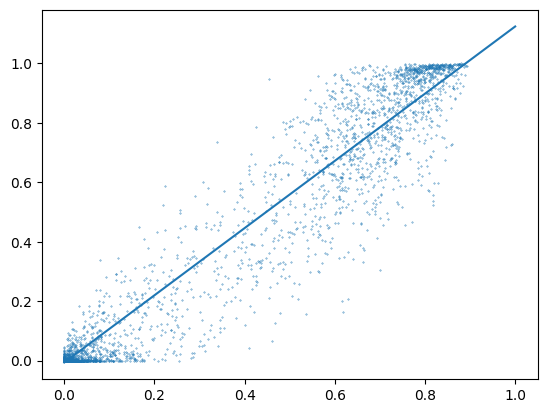

In [159]:
import matplotlib.pyplot as plt
plt.scatter(nasa_ndsi, s2, s=0.1)
x = np.linspace(0,1,100)
plt.plot(x, regression.coef_ * x + regression.intercept_, )

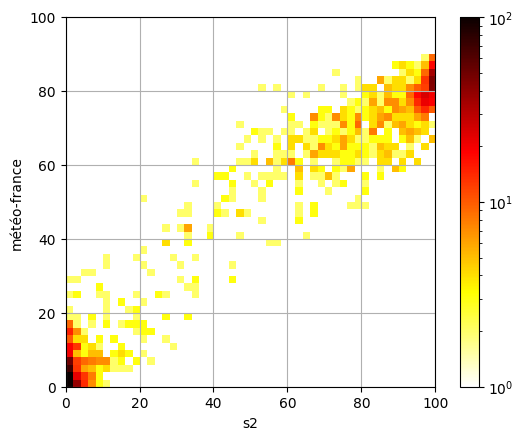

In [162]:
from scipy.ndimage import gaussian_filter
from matplotlib.pyplot import cm
import matplotlib.colors as colors
def myplot(x, y, s, bins=100):

    heatmap, xedges, yedges = np.histogram2d(x.flatten(), y.flatten(), bins=bins, range=[[0,100],[0,100]])
    heatmap = gaussian_filter(heatmap, sigma=s)

    extent = np.array([xedges[0], xedges[-1], yedges[0], yedges[-1]])
    return heatmap.T, extent

colorsmap = cm.hot_r
colorsmap.set_under('w')

fig, ax = plt.subplots()
img, extent = myplot(s2*100, nasa_ndsi*100, 0, bins=50)
pos = ax.imshow(img, extent=list(extent), origin='lower',cmap=colorsmap,norm=colors.LogNorm(vmin=1, vmax=100))
fig.colorbar(pos, ax=ax)
ax.set_xlabel('s2')
ax.set_ylabel('météo-france')
ax.grid(True)

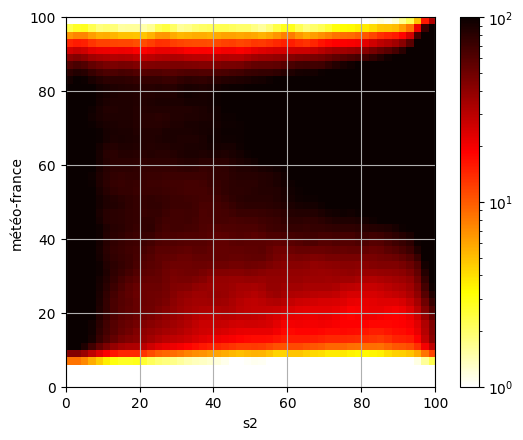

In [148]:
from scipy.ndimage import gaussian_filter
from matplotlib.pyplot import cm
import matplotlib.colors as colors
def myplot(x, y, s, bins=100):

    heatmap, xedges, yedges = np.histogram2d(x.flatten(), y.flatten(), bins=bins, range=[[0,100],[0,100]])
    heatmap = gaussian_filter(heatmap, sigma=s)

    extent = np.array([xedges[0], xedges[-1], yedges[0], yedges[-1]])
    return heatmap.T, extent

colorsmap = cm.hot_r
colorsmap.set_under('w')

fig, ax = plt.subplots()
img, extent = myplot(s2*100, nasa_ndsi*100, 1, bins=50)
pos = ax.imshow(img, extent=list(extent), origin='lower',cmap=colorsmap,norm=colors.LogNorm(vmin=1, vmax=100))
fig.colorbar(pos, ax=ax)
ax.set_xlabel('s2')
ax.set_ylabel('météo-france')
ax.grid(True)